In [2]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
print(train_images[:5], train_labels[:5])

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]] [5 0 4 1 9]


In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')# (N_Images, W, H, N_Color_Channels)
train_images = (train_images - 127.5) / 127.5 # Normalize images to [-1, 1]

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) # Flat NN take 100-d vector to 7*7*256=12,544-d vector. 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256))) # Here we prepare the data for our Conv2D, we 'generated' a 7x7 image with 256 pixel features/filters--Maybe fuzzy stamps is a good way to think about it.and
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

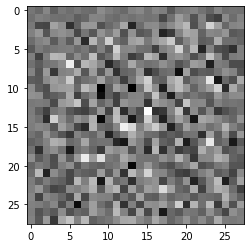

In [7]:
generator = make_generator_model()

noise = tf.random.normal([1, 99])
label = tf.constant([[5]], dtype=tf.float32)
input = tf.concat([noise, label], axis=1)

generated_image = generator(input, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [8]:
def make_discriminator_model():
    model=tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2,2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(11)) # Consider asking the discriminator to learn a representation of the digits as well. training on 11(1+10digits) outputs with a combined loss from CCEL and GAN loss

    return model


In [9]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor(
[[-0.00025731 -0.00104985 -0.000315    0.00279181 -0.00105    -0.00051139
  -0.00028502  0.00040206  0.00287304 -0.00150543 -0.00137713]], shape=(1, 11), dtype=float32)


In [10]:
cross_entropy_veracity = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy_digit = tf.keras.losses.CategoricalCrossentropy(from_logits=True)


In [11]:
def make_truth_vec(pos):
    return tf.constant([1 if i == pos else 0 for i in range(10)])

In [12]:
def discriminator_loss(real_output, real_label, fake_output, fake_label):
    assert real_output.shape[1] == 11 and fake_output.shape[1] == 11
    assert fake_label.shape == (BATCH_SIZE, 1)
    real_loss = cross_entropy_veracity(tf.ones_like(real_output[:,0]), real_output[:,0])
    fake_loss = cross_entropy_veracity(tf.zeros_like(fake_output[:,0]), fake_output[:,0])

    real_elems = tf.cast(real_label, tf.dtypes.int32)
    real_one_hotify = tf.map_fn(lambda pos:tf.one_hot(pos, 10, dtype=tf.dtypes.int32), elems=real_elems)

    fake_elems = tf.cast(fake_label, tf.dtypes.int32)
    fake_one_hotify = tf.map_fn(lambda pos:tf.one_hot(pos, 10, dtype=tf.dtypes.int32), elems=fake_elems)

    real_digit_loss = cross_entropy_digit(tf.reshape(real_one_hotify, (real_label.shape[0], 10)), real_output[:,1:])
    fake_digit_loss = cross_entropy_digit(tf.reshape(fake_one_hotify, (fake_label.shape[0], 10)), fake_output[:,1:])

    total_loss = real_loss + fake_loss + 0.1*(real_digit_loss + fake_digit_loss)
    return total_loss


In [13]:
def generator_loss(fake_output, fake_label):
    assert fake_label.shape == (BATCH_SIZE, 1)
    fake_loss = cross_entropy_veracity(tf.ones_like(fake_output[:,0]), fake_output[:,0])

    elems = tf.cast(fake_label, tf.dtypes.int32)
    one_hotify = tf.map_fn(lambda pos:tf.one_hot(pos, 10, dtype=tf.dtypes.int32), elems=elems)

    fake_digit_loss = cross_entropy_digit(tf.reshape(one_hotify, (fake_label.shape[0], 10)), fake_output[:,1:])
    return fake_loss + fake_digit_loss

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [15]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer
                                , discriminator_optimizer=discriminator_optimizer
                                , generator=generator
                                , discriminator=discriminator)

In [16]:
EPOCHS = 50
noise_dim = 99
num_examples_to_generate = 20

seed = tf.random.normal([num_examples_to_generate, noise_dim])
sample_labels = tf.constant([[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]], dtype=tf.dtypes.float32)

In [17]:
#@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    random_labels = tf.random.uniform([BATCH_SIZE, 1], maxval=9, dtype=tf.dtypes.int32)
    random_labels = tf.cast(random_labels, tf.dtypes.float32)
    input = tf.concat([random_labels, noise], axis=1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(input, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)


        gen_loss = generator_loss(fake_output, random_labels)
        disc_loss = discriminator_loss(real_output, labels, fake_output, random_labels)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [18]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(5,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 4, i+1)
        plt.imshow(predictions[i, :, :, 0]*127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f"image_at_epoch_{epoch}.png")
    plt.show()

In [22]:
def train(dataset, epochs, offset=0):
    for epoch in range(epochs):
        start = time.time()

        for image_batch, label_batch in dataset:
            train_step(image_batch, label_batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1+offset, tf.concat([tf.cast(sample_labels, tf.dtypes.float32), seed], axis=1))

        if(epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f'Time for epoch {epoch+1+offset} is {time.time()-start}')

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs+offset, tf.concat([tf.cast(sample_labels, tf.dtypes.float32), seed], axis=1))

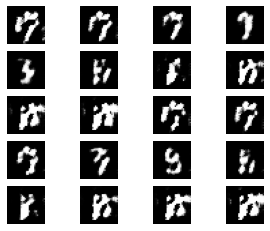

Time for epoch 7 is 39697.077684640884


KeyboardInterrupt: 

In [24]:
train(train_dataset, EPOCHS)

In [ ]:
train(train_dataset, 100, 60)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

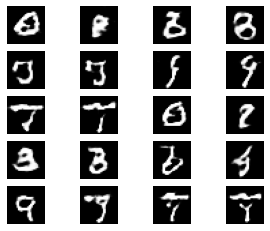

In [299]:
generate_and_save_images(generator, 50, tf.concat([sample_labels, seed], axis=1))

In [2]:
anim_file='dcgan.gif'

with imageio.get_writer(anim_file, mode="I") as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)

    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

    image = imageio.imread(filename)
    writer.append_data(image)


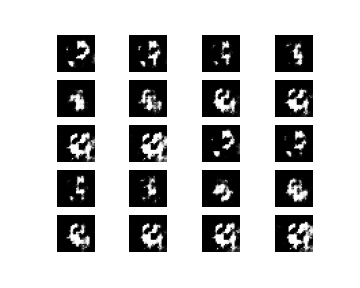

In [3]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)